In [51]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./_A_embeddings/A00_setup.py").load_module()

# SHAP Analysis For k=3 Clusters
SHAP analysis for the k=3 cluster data.  Model A01 only.

In [52]:
import numpy as np
import pandas as pd

In [53]:
from pathlib import Path
import importlib, pickle

In [54]:
import matplotlib.pyplot as plt
from sba_nn.sba_nn import sbnn_plot, sbnn_embed
import matplotlib.ticker as ticker
import textwrap

In [102]:
import seaborn as sns

In [55]:
sbnn_plot.plot_defaults()

## Import Data

In [152]:
with open(Path(setup.parent_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [67]:
random_data_long = pd.read_parquet(Path(setup.temp_path).joinpath('A21_DATA_shap_long_random.parquet'))

In [68]:
random_data_long = random_data_long[random_data_long['model']=='A01']

In [69]:
random_data_long.shape

(90000, 9)

In [70]:
(random_data_long['value'] == 0).value_counts()

value
False    85007
True      4993
Name: count, dtype: int64

In [71]:
tsne_naics_clus = pd.read_parquet(Path(setup.temp_path).joinpath('A12_DATA_tsne_info.parquet'))

In [72]:
tsne_naics_clus.columns

Index(['dset_naics_holdout', 'NAICS_orig', 'tsne_0', 'tsne_1', 'target_thresh',
       'count', 'cluster_003', 'NAICS_desc', 'NAICS_sector_desc',
       'NAICS_3_desc', 'NAICS_4_desc', 'NAICS_5_desc', 'year_min', 'year_max'],
      dtype='object')

In [73]:
random_data_long = random_data_long \
    .merge(tsne_naics_clus[['cluster_003', 'NAICS_orig']].drop_duplicates(), on='NAICS_orig')

In [74]:
random_data_long.shape

(90000, 10)

In [75]:
random_data_long['cluster_003'].value_counts(dropna=False)

cluster_003
2    49122
1    22896
0    17982
Name: count, dtype: int64

##### Get human readable cluster labels

In [76]:
with open(Path(setup.temp_path).joinpath('A12_DATA_cluster_labels.pkl'), 'rb') as fin:
    cluster_labels = pickle.load(fin)

In [77]:
cluster_dtype = pd.CategoricalDtype(categories = cluster_labels.values())

In [78]:
random_data_long['cluster'] = random_data_long['cluster_003'] \
    .apply(lambda x: cluster_labels[x]) \
    .astype(cluster_dtype)

In [79]:
random_data_long['cluster'].value_counts(dropna=False)

cluster
med (2)     49122
high (1)    22896
low (0)     17982
Name: count, dtype: int64

In [82]:
random_data_long[random_data_long['variable'] == 'CreateJob']['variable_NAICS'].value_counts()

variable_NAICS
other features    5000
Name: count, dtype: int64

## Feature importance by cluster

In [83]:
# All feature importance
feat_imp_raw = random_data_long \
    .groupby(['cluster', 'variable', 'variable_NAICS'], observed =True) \
    [['value', 'value_abs']] \
    .agg('mean') \
    .reset_index()

In [49]:
random_data_long.columns

Index(['model', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS_orig',
       'variable', 'value', 'value_abs', 'variable_NAICS', 'cluster_003',
       'cluster'],
      dtype='object')

#### Group all NAICS together

In [86]:
# group all NAICS together to make plot nicer
feat_imp_naics_1 =  random_data_long[random_data_long['variable_NAICS'] == 'NAICS features'] \
    .groupby(['cluster', 'LoanNr_ChkDgt'], observed =True) \
    ['value'] \
    .agg('sum') \
    .reset_index()
feat_imp_naics_1['value_abs'] = np.abs(feat_imp_naics_1['value'])
feat_imp_naics =  feat_imp_naics_1 \
    .groupby(['cluster']) \
    [['value_abs', 'value']] \
    .agg('mean') \
    .reset_index() 
feat_imp_naics['variable'] = 'NAICS'

In [87]:

feat_imp_naics_grp = pd.concat([feat_imp_raw[feat_imp_raw['variable_NAICS'] == 'other features'],
                                                 feat_imp_naics])


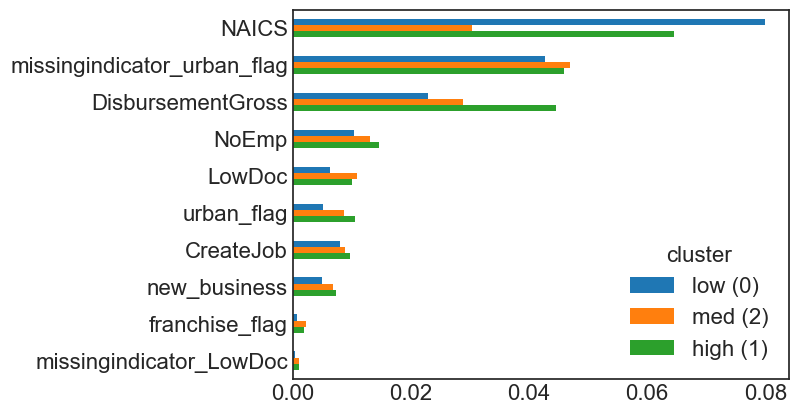

In [88]:
fig, ax = plt.subplots()
sbnn_plot.barh_top_n_pair(feat_imp_naics_grp, x='variable', columns='cluster',
                             legend_title='cluster', ax=ax)
fig.savefig(Path(setup.temp_path).joinpath('A22_cluster_feat_imp.png'))

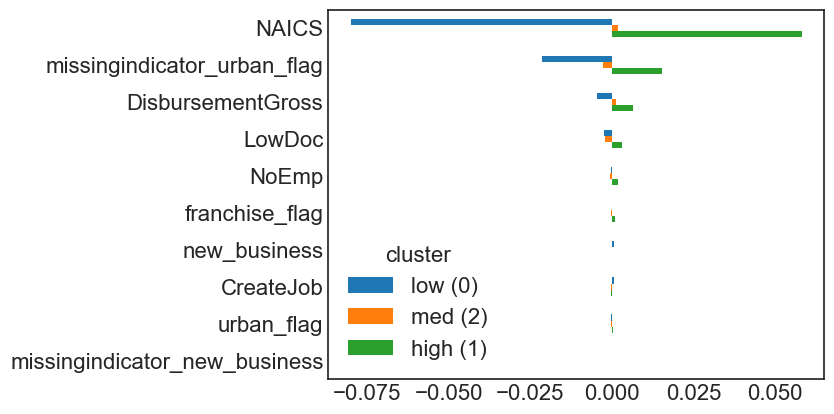

In [89]:
fig, ax = plt.subplots()
sbnn_plot.barh_top_n_pair(feat_imp_naics_grp, x='variable', columns='cluster',
                          y='value',
                             legend_title='cluster', ax=ax)
fig.savefig(Path(setup.temp_path).joinpath('A22_cluster_feat_imp_values.png'))

#### NAICS vs. Other Importance by Cluster

In [90]:
# group all NAICS together to make plot nicer
feat_imp_naics_voth_1 =  random_data_long \
    .groupby(['cluster', 'variable_NAICS', 'LoanNr_ChkDgt'], observed =True) \
    ['value'] \
    .agg('sum') \
    .reset_index()
feat_imp_naics_voth_1['value_abs'] = np.abs(feat_imp_naics_voth_1['value'])
feat_imp_naics_voth =  feat_imp_naics_voth_1 \
    .groupby(['cluster', 'variable_NAICS']) \
    [['value_abs', 'value']] \
    .agg('mean') \
    .reset_index() 


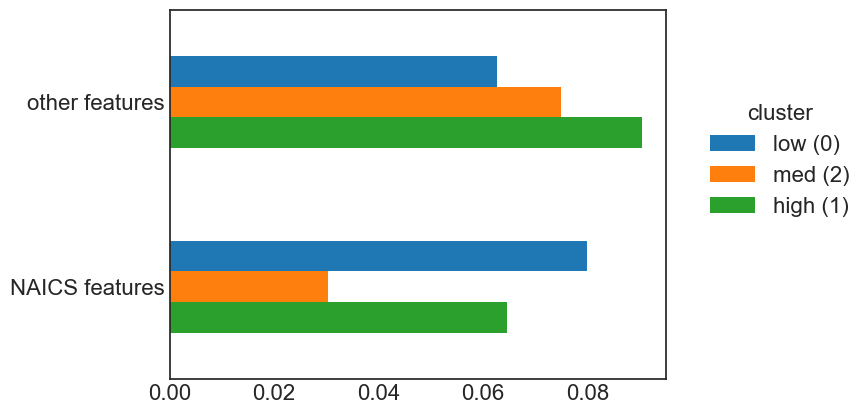

In [91]:
fig, ax = plt.subplots()
sbnn_plot.barh_top_n_pair(feat_imp_naics_voth, x='variable_NAICS', columns='cluster',
                             legend_title='cluster', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 0.8), title='cluster')
fig.savefig(Path(setup.temp_path).joinpath('A22_cluster_feat_imp_naics_voth.png'))

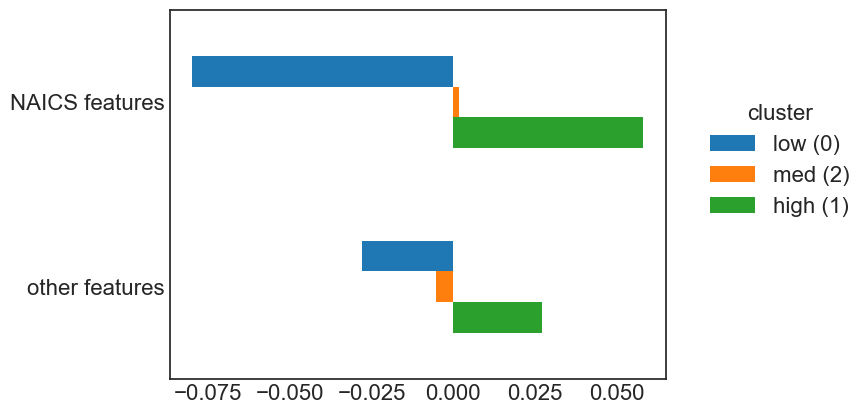

In [92]:
fig, ax = plt.subplots()
sbnn_plot.barh_top_n_pair(feat_imp_naics_voth, x='variable_NAICS', columns='cluster',
                          y='value', legend_title='cluster', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 0.8), title='cluster')
fig.savefig(Path(setup.temp_path).joinpath('A22_cluster_feat_imp_naics_voth_value.png'))

## Histograms

#### NAICS vs not

In [117]:
# Colors to use
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_dict = {list(cluster_labels.values())[i]:color_list[i] for i in range(len(cluster_labels.keys()))}
color_dict

{'low (0)': '#1f77b4', 'med (2)': '#ff7f0e', 'high (1)': '#2ca02c'}

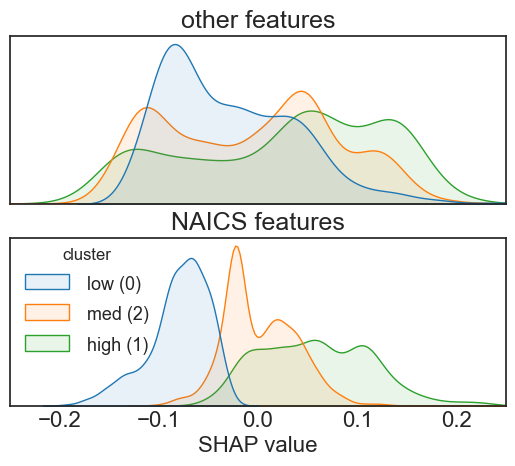

In [253]:
fig, ax = plt.subplots(2, 1, sharex=True)
i = 0
for naics_type in ['other features', 'NAICS features']:
    this_data = feat_imp_naics_voth_1[feat_imp_naics_voth_1['variable_NAICS'] == naics_type]
    s = sns.kdeplot(data=this_data, x='value', hue='cluster', 
                fill=True, alpha=0.1,common_norm=False,
                palette=color_list[:3], ax=ax[i])
    
    ax[i].set_title(naics_type)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim([-0.25, 0.25])
    ax[i].set_xlabel('SHAP value')
    i+=1
ax[0].get_legend().remove()
ax[1].get_legend().get_title().set_fontsize(12)
sns.move_legend(s, "upper left", bbox_to_anchor=(-0.01, 1.06))
plt.setp(ax[1].get_legend().get_texts(), fontsize=13)
fig.savefig(Path(setup.temp_path).joinpath('A22_PLOT_hist_naics_voth.png'))

##### Selected features

In [254]:
features_numeric_sel = ['DisbursementGross', 'missingindicator_urban_flag', 'NoEmp', 'LowDoc']

In [255]:
features_numeric_sel

['DisbursementGross', 'missingindicator_urban_flag', 'NoEmp', 'LowDoc']

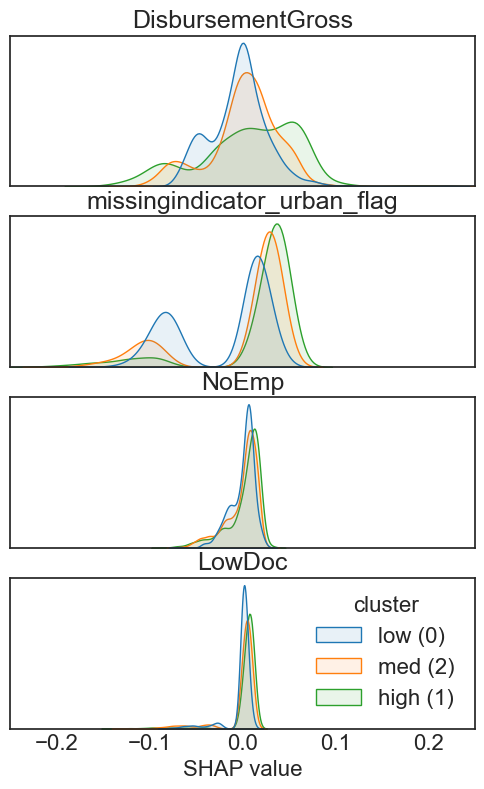

In [258]:
fig, ax = plt.subplots(len(features_numeric_sel), 1, sharex=True,
                      figsize=(6, 1 + 2*len(features_numeric_sel)))
i = 0
for feature in features_numeric_sel:
    this_data = random_data_long[random_data_long['variable'] == feature]
    s = sns.kdeplot(data=this_data, x='value', hue='cluster', 
                fill=True, alpha=0.1,common_norm=False,
                palette=color_list[:3], ax=ax[i])
    
    ax[i].set_title(feature)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim([-0.25, 0.25])
    ax[i].set_xlabel('SHAP value')
    if i < len(features_numeric_sel) -1:
        ax[i].get_legend().remove()
    i+=1
sns.move_legend(s, "lower right", )
fig.savefig(Path(setup.temp_path).joinpath('A22_PLOT_hist_numeric.png'))
